In [1]:
import socket

NB='test'
DESCRIPTION='test notebook'
HOST = socket.gethostname()
HOST

In [2]:
import warnings
import os
from pathlib import Path

import mlflow
from dataclasses import dataclass
from dataclasses import asdict

import pandas as pd
import lightgbm as lgb
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score, average_precision_score, mean_squared_log_error
from sklearn.preprocessing import LabelEncoder

#from my_utils import get_notebook_path

warnings.simplefilter('ignore')
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 25)

In [3]:
ROOT_DIR = Path('./')
DATA_DIR = ROOT_DIR / Path('data')

In [4]:
class Config:
    SR = 48000
    N_LABEL = 24
    N_FOLD = 5
    RANDOM_SATE = 42
    LR = 0.15
    PATIENCE = 30
    EPOCH = 300
    BATCH_SIZE = 6
    N_REPEATS = 3
    SKIP_EVALUATE_NUM = 5

In [5]:
train_df = pd.read_csv(DATA_DIR / Path('train.csv'))
test_df = pd.read_csv(DATA_DIR / Path('test.csv'))

display(train_df.shape)
display(train_df.head(5))
display(test_df.shape)
display(test_df.head(5))

(891, 12)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(418, 11)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## feature and target

In [6]:
target = 'Survived'
del_columns = ['Survived', 'Name']

features = list(set(train_df.columns) - set(del_columns))
features

['Pclass',
 'Parch',
 'PassengerId',
 'Age',
 'Sex',
 'Fare',
 'Ticket',
 'Cabin',
 'Embarked',
 'SibSp']

## train lgbm

### metrix

In [7]:
def evaluation(true, pred):
    return roc_auc_score(true, pred)

### encording

In [8]:
# 数値でないカラムをLabelEncording
categoricals = ['Sex', 'Ticket', 'Cabin','Embarked']
features = list(set(features) | set(categoricals))
for c in categoricals:
    le = LabelEncoder()
    le.fit(train_df.append(test_df)[c].astype(str))
    train_df[c] = le.transform(train_df[c].astype(str))
    test_df[c] = le.transform(test_df[c].astype(str))

# Count encoding
count_enc = ['Sex', 'Ticket', 'Cabin', 'Embarked']
count_features = []
for c in count_enc:
    _count = train_df.append(test_df)[c].astype(str).value_counts().to_dict()
    train_df[f'{c}_count'] = train_df[c].astype(str).map(_count)
    test_df[f'{c}_count'] = test_df[c].astype(str).map(_count)
    count_features.append(f'{c}_count')
features = list(set(features) | set(count_features))

### train

In [9]:
params = {
    'n_estimators':5000,
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'objective': 'binary',
    'n_jobs': -1,
    'seed': Config.RANDOM_SATE,
    'learning_rate': 0.01,
}

# TargetEncording Config
target_enc = ['Sex', 'Ticket', 'Cabin', 'Embarked'] # 集計対象カラム
target_enc_key = ['Survived'] # 集計するキー

oof_preds = np.zeros(len(train_df))
y_pred = np.zeros(len(test_df))
models = []
cv_scores = {}
skf = StratifiedKFold(n_splits=Config.N_FOLD, random_state=Config.RANDOM_SATE, shuffle=True)
for fold, (train_index, test_index) in enumerate(skf.split(train_df[features], train_df[target])):

    print(f'====== fold {fold} ======')

    # TrainとTestに分割
    x_train, x_val = train_df.copy().iloc[train_index][features], train_df.copy().iloc[test_index][features]
    y_train, y_val =  train_df.iloc[train_index][target], train_df.iloc[test_index][target]

    test = test_df[features]

    # Target Encoding
    if len(target_enc) > 0:
        for t in target_enc_key:
            for c in target_enc:
                x_train[f'{c}_target_enc_by_{t}'] = train_df.iloc[train_index][c].map(train_df.iloc[test_index].groupby(c)[t].mean().to_dict())
                x_val[f'{c}_target_enc_by_{t}'] = train_df.iloc[test_index][c].map(train_df.groupby(c)[t].mean().to_dict())
                test[f'{c}_target_enc_by_{t}'] = test_df[c].map(train_df.groupby(c)[t].mean().to_dict())
            
    train_features = x_train.columns.to_list()

    # create Dataset
    train_set = lgb.Dataset(x_train, y_train, categorical_feature=categoricals, free_raw_data=False)
    val_set = lgb.Dataset(x_val, y_val, categorical_feature=categoricals, free_raw_data=False)

    # train
    model = lgb.train(params, train_set, valid_sets=[train_set, val_set], verbose_eval=100, early_stopping_rounds=100)#, feval=rmsle_eval)
    
    models.append(model)

    fold_pred = model.predict(x_val)

    score = evaluation(y_val, fold_pred)
    cv_scores[f'cv{fold}'] = score

    oof_preds[test_index] = fold_pred

    y_pred += model.predict(test) / Config.N_FOLD

    print(f'cv score is {score}')

oof_score = evaluation(train_df[target], oof_preds)
print(f'OOF score is {oof_score}')

====== fold 0 ======
[LightGBM] [Info] Number of positive: 273, number of negative: 439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 511
[LightGBM] [Info] Number of data points in the train set: 712, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383427 -> initscore=-0.475028
[LightGBM] [Info] Start training from score -0.475028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

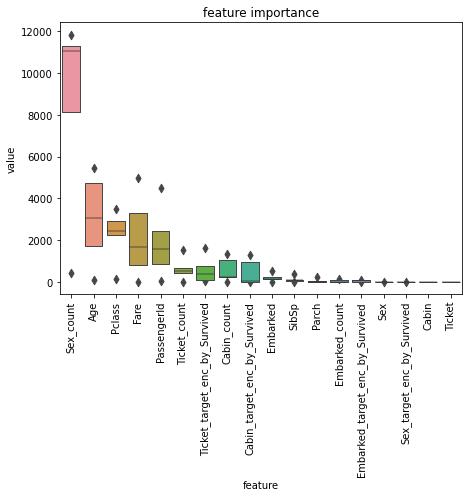

In [10]:
df_importance = None

for i, model in enumerate(models):
    if df_importance is None:
        _df = pd.DataFrame([model.feature_importance(importance_type='gain'), train_features]).T
        _df.columns = [f'model_{i}_gain', 'feature']
        df_importance = _df
    else:
        _df = pd.DataFrame([model.feature_importance(importance_type='gain'), train_features]).T
        _df.columns = [f'model_{i}_gain', 'feature']
        df_importance = df_importance.merge(_df, how='outer', on='feature')

df_imp = df_importance
df_imp['mean'] = df_imp[[f'model_{i}_gain' for i in range(len(models))]].mean(axis=1)
order = df_imp.sort_values('mean', ascending=False)['feature'].tolist()

df_imp = pd.melt(df_imp, id_vars=['feature'], value_vars=[f'model_{i}_gain' for i in range(len(models))])
df_imp['value'] = df_imp['value'].astype(float)

fig, ax = plt.subplots(figsize=(len(df_imp['feature'].drop_duplicates()) * .4, 5))
sns.boxenplot(x="feature", y="value", data=df_imp, order=order)
ax.tick_params(axis='x', rotation=90)
ax.set_title('feature importance')
plt.show()

## log mlflow 

In [11]:
"""param_dict = {k:v for k, v in vars(Config).items() if not k.startswith('__')}

remote_server_uri = "http://192.168.1.99:5000/"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://192.168.1.99:9000"
os.environ["AWS_ACCESS_KEY_ID"] = "minio-access-key"
os.environ["AWS_SECRET_ACCESS_KEY"] = "minio-secret-key"

mlflow.set_tracking_uri(remote_server_uri)
mlflow.set_experiment("atma10")
with mlflow.start_run():
    mlflow.set_tag('NB', NB)
    mlflow.set_tag('DESCRIPTION', DESCRIPTION)
    mlflow.set_tag('HOST', HOST)
    
    mlflow.log_param("a", 1)
    mlflow.log_param('features', features)
    mlflow.log_params(param_dict)
    mlflow.log_params(params)
    
    mlflow.log_metric('oof', oof_score)
    mlflow.log_metrics(cv_scores)
    
    mlflow.log_artifact(get_notebook_path())"""

'param_dict = {k:v for k, v in vars(Config).items() if not k.startswith(\'__\')}\n\nremote_server_uri = "http://192.168.1.99:5000/"\nos.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://192.168.1.99:9000"\nos.environ["AWS_ACCESS_KEY_ID"] = "minio-access-key"\nos.environ["AWS_SECRET_ACCESS_KEY"] = "minio-secret-key"\n\nmlflow.set_tracking_uri(remote_server_uri)\nmlflow.set_experiment("atma10")\nwith mlflow.start_run():\n    mlflow.set_tag(\'NB\', NB)\n    mlflow.set_tag(\'DESCRIPTION\', DESCRIPTION)\n    mlflow.set_tag(\'HOST\', HOST)\n    \n    mlflow.log_param("a", 1)\n    mlflow.log_param(\'features\', features)\n    mlflow.log_params(param_dict)\n    mlflow.log_params(params)\n    \n    mlflow.log_metric(\'oof\', oof_score)\n    mlflow.log_metrics(cv_scores)\n    \n    mlflow.log_artifact(get_notebook_path())'